In [1]:
%matplotlib inline

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import pycollocation

In [101]:
def spence_model(y, n, alpha, **params):
    return [(n**-1 - alpha * n * y**(alpha - 1)) / y**alpha] 

def initial_condition(y, n, nL, alpha, **params):
    return [n - nL]

def yL(nL, alpha):
    return (nL**2 * alpha)**(1 / (1 - alpha))

params = {'nL': 1.0, 'alpha': 0.15}

classic_spence_ivp = pycollocation.problems.IVP(initial_condition, 1, 1, params,
                                                spence_model)

In [102]:
def initial_mesh(yL, yH, num, problem):
    ys = np.linspace(yL, yH, num=num)
    ns = problem.params['nL'] + np.sqrt(ys)
    return ys, ns


In [103]:
bspline_basis = pycollocation.basis_functions.BSplineBasis()
solver = pycollocation.solvers.Solver(bspline_basis)

boundary_points = (yL(**params), 10)
ys, ns = initial_mesh(*boundary_points, num=250, problem=classic_spence_ivp)

tck, u = bspline_basis.fit([ns], u=ys, k=5, s=0)
knots, coefs, k = tck
initial_coefs = np.hstack(coefs)

basis_kwargs = {'knots': knots, 'degree': k, 'ext': 2}
nodes = np.linspace(*boundary_points, num=249) 
solution = solver.solve(basis_kwargs, boundary_points, initial_coefs,
                        nodes, classic_spence_ivp)


In [104]:
solution.result.success

True

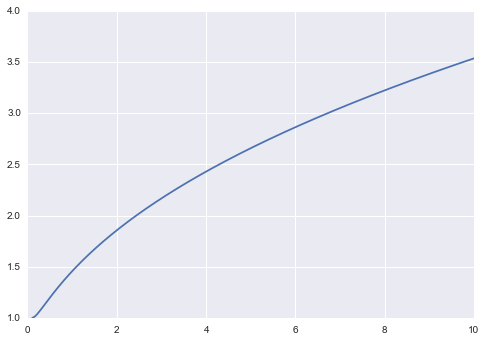

In [106]:
n_soln, = solution.evaluate_solution(ys)
plt.plot(ys, n_soln)
plt.show()

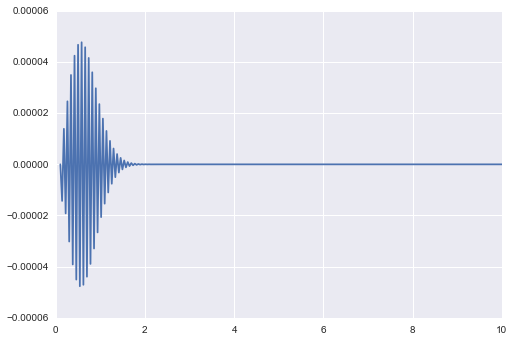

In [107]:
n_resids, = solution.evaluate_residual(ys)
plt.plot(ys, n_resids)
plt.show()

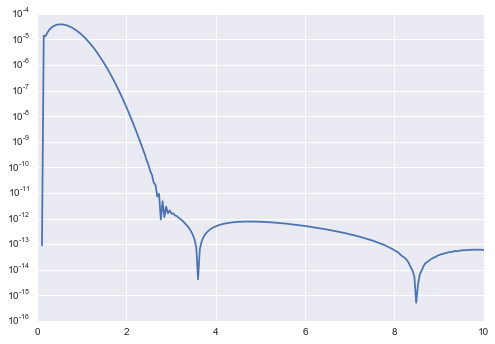

In [108]:
n_normalized_resids, = solution.normalize_residuals(ys)
plt.plot(ys, np.abs(n_normalized_resids))
plt.yscale('log')
plt.show()

In [109]:
def spence_analytic_solution(y, nL, alpha):
    """
    Analytic solution to the differential equation describing the signaling
    equilbrium of the Spence (1974) model.
    
    """    
    # compute analytic solution for worker type given y
    D = ((1 + alpha) / 2) * (nL / yL(nL, alpha)**-alpha)**2 - yL(nL, alpha)**(1 + alpha)
    return y**(-alpha) * (2 * (y**(1 + alpha) + D) / (1 + alpha))**0.5

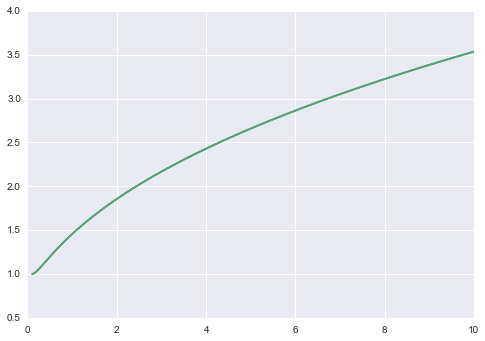

In [110]:
plt.plot(ys, spence_analytic_solution(ys, **params))
plt.plot(ys, n_soln)
plt.show()